<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fmottes/unito-neural-networks/blob/master/02%20-%20Logistic%20Regression%20and%20SGD.ipynb">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:175px;"/>
    </a>
  </td>
</table>

# <center> **Neural Networks** (MFN0824) </center>

### Lectures: _Dr. Matteo Osella_
### Notebooks: _Francesco Mottes_
<br>

---

The reference book for the practical part of this course is:
- *Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow - A. Géron*

There is also a [github page](https://github.com/ageron/handson-ml2) where you can find some notebooks with the code from the book, a good place to start if you want to look into more advanced topics.

**NOTE:** You can easily (and legally) find online a raw and unedited version of the second edition of the book, released by the author before the book was finished. Be advised that, besides not being the revised version, **it is not even the whole book**.

### References:
- Numpy Docs: https://numpy.org/doc/1.18/
- Matplotlib Docs: https://matplotlib.org/
- Scikit-learn Docs: https://scikit-learn.org/

# <center> **02 - Logistic Regression and SGD** </center>

In this notebook we will present the bare-bone implementation of a simple (and in many ways incomplete) logistic regression model, trained with (Stochastic) Gradient Descent. Recall the working diagram of the logistic regression:

![The Perceptron](img/perceptron.png)

It is identical to the perceptron, except for one crucial difference: the activation function. The activation is not a simple step function, it is now **differentiable**. This means that we will be able to calculate the gradient of the loss function (which must also be differentiable) with respect to the weights of the model. Once we know the gradient we can use the (Stochastic) Gradient Descent procedure to optize the weights of our model.

In our case we will use the "classic" setting for logistic regression: *sigmoid* function as activation and *mean squared error* loss function. The mathematical formulation of our model will thus be:

$$
\hat{y} = \sigma (z) = \sigma ( \textbf{x} \cdot \textbf{w} + b) = \sigma (\displaystyle\sum_{i=0}^{D} x_i w_i + b)
$$

where: 

$$
z = \displaystyle\sum_{i=0}^{D} x_i w_i + b
$$

The logistic sigmoid activation function has the form:

$$
\sigma (z) = \frac{1}{1+e^{-z}}
$$

and the peculiarity that its derivative can be written as:

$$
\sigma'(z) = \sigma(z) (1 - \sigma(z))
$$

Now to the loss function, we use the *cross entropy*:

$$
E(\textbf{w}) = \displaystyle\sum_{i=0}^{N} [y_i log(\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i)]
$$

Note that the dependency of the loss function on the weights **w** is hidden in the definition of the predicted label $\hat{y}$. Other types of differentiable loss functions can be used as well, depending on the purpose (e.g. mean squared error loss or others).

Suppose now we consider one sample at a time, and we want to calculate the weights' gradient with respect to a fixed sample. It means we want to calculate:

$$
\nabla_{\textbf{w}} E = \left( \frac{\partial E}{\partial w_1}, \frac{\partial E}{\partial w_2}, \cdots , \frac{\partial E}{\partial w_N} \right)
$$

We can start calculating one generic component of the gradient, using the chain rule:

$$
\frac{\partial E}{\partial w_i} = \frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} \frac{\partial z}{\partial w_i} = \frac{(\hat{y}-y)}{\hat{y}(1 - \hat{y})} \sigma'(z) x_i = (\hat{y}-y)x_i
$$

The last passage is done by plugging in the formula for $\sigma'(z)$ and remembering that $\hat{y}=\sigma(z)$. The formula for the bias term is even simpler, since in that case $x_i = 1$. So now we can calculate the gradient of the loss function with respect to the weights for each fixed sample. Then we can use the usual gradient descent algorithm to update the weights taking one single sample at a time:

$$
w_i \leftarrow w_i + \eta \frac{\partial E}{\partial w_i} \\
b \leftarrow b + \eta \frac{\partial E}{\partial b}
$$

This procedure is what is strictly called **Stochastic Gradient Descent (SGD)**. We can also take a bunch of samples at a time, calculate the gradient for each of the samples and take an average to use for the updates: this version is indeed the most used and it's called **mini-batch SGD**. The upper limit of this procedure is that we mediate the gradient on all of the samples at each step: in this way we get the **(full) batch gradient descent**. This last approach is hardly ever used in practice.

Below you can find a minimal implementation of the procedures shown above, with a simple application to the MOONS synthetic dataset. The implementation in not conceived with performance in mind, rather with (hopefully) the aim of showing all the inner workings of the algorithm with some degree of clarity. High performance implementations can be found in standard machine learning packages, e.g. the *scikit-learn* package.

### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

### Define activation functions

In [5]:
#SIGMOID ACTIVATION AND DERIVATIVE

def sigmoid(z):
    return 1/(1+np.exp(-z))

#sigmoid derivative
def d_sigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

### Define losses

In [6]:
#MEAN SQUARED ERROR LOSS
#try statement is there to deal also with the case where y and y_pred are not arrays

def MSE(y, y_pred):
    try:
        loss = np.sum((y-y_pred)**2)/(2*len(y))
    except TypeError:
        loss = np.sum((y-y_pred)**2)/2
        
    return loss

#derivative of MSE w.r.t. y_pred
def d_MSE(y, y_pred):
    try:
        d = (y_pred-y)/len(y)
    except TypeError:
        d = (y_pred-y)
        
    return d


#----------------------------------------
#CROSS ENTROPY LOSS

def cross_entropy(y, y_pred):
    loss = np.sum(y*np.log(y_pred)+(1-y)*np.log(1-y_pred))
    
    return loss

def d_cross_entropy(y, y_pred):
    
    d = np.sum((y_pred-y)/(y_pred*(1-y_pred)))
    
    return d

### Define learning algorithm

In [7]:
class LogisticRegression():
    
    def __init__(self, input_shape=None, activation='sigmoid', d_activation=None, loss='MSE', d_loss=None):
        
        self.input_shape = input_shape
        
        #if shape of input is known initialize weights
        #otherwise leave it for the training loop
        if None == self.input_shape:
            self.w = None
            self.b = None
        else:
            self.initialize_weights()
            
            
        #select activation function
        if 'sigmoid' == activation:
            self.activation = sigmoid
            self.d_activation = d_sigmoid
            
        
        #select loss function
        if 'MSE' == loss:
            self.loss = MSE
            self.d_loss = d_MSE
            
        elif 'cross_entropy' == loss:
            self.loss = cross_entropy
            self.d_loss = d_cross_entropy
            
            
        return
        
    
    #WEIGHT INITIALIZATION
    def initialize_weights(self):
        self.w = np.random.uniform(-1,1,self.input_shape)
        self.b = 0.
    
    
    #PREDICT P(Y=1)
    def predict_proba(self, X, return_z=False):
        
        z = X.dot(self.w)+self.b
        y_pred = self.activation(z)
        
        if return_z:
            return y_pred, z
        else:
            return y_pred
        
        
    #PREDICT 0/1 LABEL
    def predict(self, X):
        
        y_pred = predict_proba(X)
        return (y_pred>.5).astype(int)
    
    
        
    #calculate weight gradient for a single sample
    def _gradient(self, x, y):
        
        y_pred, z = self.predict_proba(x, return_z=True)
        
        w_grad = self.d_loss(y,y_pred)*self.d_activation(z)*x
        b_grad = self.d_loss(y,y_pred)*self.d_activation(z)*1
        
        return w_grad, b_grad, y_pred
        
        
        
    #performs a single SGD step (that is, weight update)
    #using a single batch of data
    def SGDstep(self, X_batch, y_batch):
        
        mean_wgrad = np.zeros(self.w.shape)
        mean_bgrad = 0
        y_pred_batch = []
        
        #calculate gradient and training loss on batch
        for x, y in zip(X_batch,y_batch):
            w_grad, b_grad, y_pred = self._gradient(x,y)
            
            mean_wgrad += w_grad
            mean_bgrad += b_grad
            
            y_pred_batch.append(y_pred)
            
            
        mean_wgrad = mean_wgrad/self.batch_size
        mean_bgrad = mean_bgrad/self.batch_size

        #calculate training loss on this batch
        batch_loss = self.loss(y_batch, y_pred_batch)
        
        
        #update weights
        self.w -= self.learning_rate*mean_wgrad
        self.b -= self.learning_rate*mean_bgrad
        
        return batch_loss
        
        

        
    #main training loop
    def train(self, X, y, batch_size=1, epochs=10, learning_rate=.001):
        
        if self.w is None:
            self.initialize_weights()
            
        #SET OPTIMIZER'S HYPERPARAMETERS
        self.batch_size = batch_size
        self.n_batches = np.round(X.shape[0]/self.batch_size, decimals=0)
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        #index of each sample, useful for shuffling
        self.data_index = np.arange(X.shape[0])
        
        self.training_loss = []
        
        #loop through epochs
        for epoch in tqdm(range(epochs), total=epochs, desc='TRAINING EPOCHS:'):
            
            #shuffle data index at beginning of each epoch
            np.random.shuffle(self.data_index)
            
            #split indexing array into batches
            batches_idx = np.array_split(self.data_index, self.n_batches)
            
            loss_buff = []
            #make update step for each batch of data
            for batch in batches_idx:
                loss_buff.append(self.SGDstep(X[batch], y[batch]))
                
            #calculate mean epoch loss
            self.training_loss.append(np.mean(loss_buff))
            
        return self.training_loss

### GENERATE SEMI-CIRCLES

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [9]:
N = 1000
test_size = .1

In [10]:
#generate two semi-circles, one for each class, of 2D data
#(we don't get to choose the data dimension here, it's always 2D)
X_moon, y_moon = make_moons(n_samples=N, noise=.1)

#generate training and test set
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=test_size)

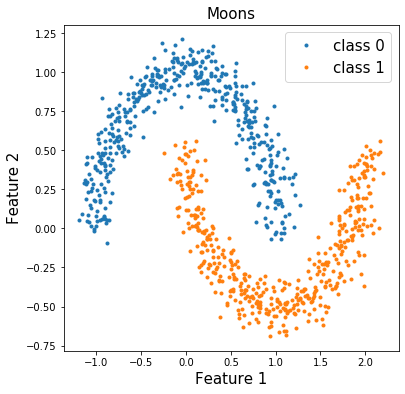

In [11]:
#plot the blob dataset

fig, ax = plt.subplots(figsize=(6,6))

fontsize = 15

#plot both classes as above, but all at once
for cat in np.unique(y_moon_train): #loop over unique class IDs
    
    mask = y_moon_train == cat
    
    ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', markersize=3, label='class {}'.format(cat))



ax.legend(fontsize=fontsize)

ax.set_xlabel('Feature 1', fontsize=fontsize)
ax.set_ylabel('Feature 2', fontsize=fontsize)

ax.set_title('Moons', fontsize=fontsize);

### Logistic Regression on MOONS

In [12]:
#create logistic regression object

lr = LogisticRegression(input_shape=2)

In [13]:
#training hyperparameters

epochs = 300
batch_size = 30
learning_rate = .001

In [14]:
#train logistic regression with SGD
train_loss = lr.train(X_moon_train, y_moon_train, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)

TRAINING EPOCHS:: 100%|██████████| 300/300 [00:08<00:00, 36.62it/s]


In [15]:
print('Training loss:\t', MSE(lr.predict_proba(X_moon_train), y_moon_train))
print('Test loss:\t', MSE(lr.predict_proba(X_moon_test), y_moon_test))

Training loss:	 0.09018532476594106
Test loss:	 0.09120567098330733


In [16]:
print(train_loss[-1])

0.0902270055366241


We can now visualize the prediction field of the trained model. Note two things. Firstly, this model still can draw only **linear** separation boundaries, as in the case of the perceptron. In order to have more sophisticated ones we must resort to more sophisticated models (one such model, even if not the only one, is a neural network). Secondly, due to the softer non-linearity (with respect to the perceptron), we now have probability predictions, visualized as areas of different intensity on the map. Note that zones further away from the separation line are assigned a higher confidence of belonging to a given class.

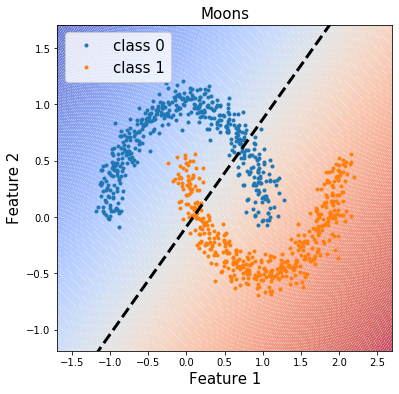

In [17]:
#visualize prediction boundary on moons dataset

fig, ax = plt.subplots(figsize=(6,6))

fontsize = 15

#----------------------------------------------------------------
### VISUALIZE BLOBS TRAINIG DATASET (with correct classification)


#plot the points of the first class:
mask = y_moon_train == 0

ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', markersize=3, label='class 0') #plot first feature on x-axis and second feature on y-axis


#plot the points of the second class:
mask = y_moon_train == 1

ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', markersize=3, label='class 1') #plot first feature on x-axis and second feature on y-axis

#----------------------------------------------------------------
### Visualize logistic regression prediction field

# generate square mesh of points to evaluate, with "n_pts_side" ponits per side
n_pts_side = 500
pad = .5

#extrema change based on generated points
xx_min = X_moon[:,0].min()-pad
xx_max = X_moon[:,0].max()+pad

yy_min = X_moon[:,1].min()-pad
yy_max = X_moon[:,1].max()+pad

xx = np.linspace(xx_min, xx_max, n_pts_side)  
yy = np.linspace(yy_min, yy_max, n_pts_side)

#plot decision line
ax.plot(xx, (-lr.b-lr.w[0]*xx)/lr.w[1], 'k--', linewidth=3)
ax.set_ylim(yy_min, yy_max)


# plot decision field
xx, yy = np.meshgrid(xx, yy)

zz = lr.predict_proba(np.vstack([xx.ravel(),yy.ravel()]).T) #generate predictions for each point in field
zz = zz.reshape(xx.shape)

cnt = ax.contourf(xx, yy, zz, levels=300, cmap='coolwarm', alpha=.5)

#----------------------------------------------------------------

ax.set_xlim(xx_min, xx_max)
ax.set_ylim(yy_min, yy_max)

ax.legend(fontsize=fontsize)

ax.set_xlabel('Feature 1', fontsize=fontsize)
ax.set_ylabel('Feature 2', fontsize=fontsize)

ax.set_title('Moons', fontsize=fontsize);

## <center> **Exercises** </center>

### Upgrade the code

A good way to understand the inner workings of the code is to try and upgarde it to a better version. In order to make sensible modifications you will need to understand what is going on at some level of detail.

There are a lot of upgrdes that can be made to the code: make it support more loss functions and more activation functions, add support for calculating also the validation error during training, add support for calculation of additional metrics during training (e.g. accuracy), improve performance by vectorizing some parts of the code (e.g. the gradient calculation can be upgraded all the gradients of the batch at once and return the mean directly). 

### Visualize the loss function on MOONS

Since the input parameter space in this case is 2D (if we neglect the bias term), we can directly visualize the loss landscape of the model! The idea is very similar to the one in the plot visualizing the prediction field, only in this case we have the two weights on the two axes and the color is given by the loss associated with that particular couple of weights.

The idea is the following. First choose the ranges of w1 and w2 that you want to probe (in this case the interval \[-1,1\] should be good). Then generate a grid of points (w1,w2) and for each point use the weights in the couple to make predictions on all of the dataset. Finally compute the loss associated with the predictions and plot it in the same way in which the prediction field is plotted above (you can actially re-use a lot of the structure of that plotting code, with some modifications). Plot the weights of the trained model on the energy landscape, where are they?